# Quickstart

In this tutorial we show how to obtain a mock-catalogue using `scampy`.

First, we will load a DM halo/sub-halo hierarchy obtained with the SUBFIND algorithm applied on a $z = 0$ GADGET snapshot.
Then, we will 

1. populate the catalogue with galaxies

2. associate to each galaxy a luminosity


First of all, we populate the namespaces from numpy and matplotlib (it would be enough to state `import numpy as np` for working, this is mostly useful for plotting)

In [1]:
import numpy as np
# %pylab inline

Now, we import the `catalogue` module from `scampy`:

In [2]:
from scampy import catalogue

We now build an object of type catalogue and read the halo/sub-halo hierarchy from the binary output of the SUBFIND algorithm.

**Note** that, tipically, these outputs are given as a set of files with a common base-name, e.g. `subhalo_tab.0` for the first file in the set. Here we just need to provide the common name of all the files, i.e. `subhalo_tab`.

In [3]:
cat = catalogue.catalogue()
cat.read_hierarchy_from_gadget( "input/subhalo_tab" )

The catalogue we provide in the `input` directory has been obtained for a simulation box with side-lenght $L_\text{box} = 512\ \text{Mpc}/h$, thus we can define a `volume` variable that we will use later:

In [4]:
volume = 512**3

## 1. Populate catalogue

We will now populate the above catalogue with a 4-parameters HOD model:
\begin{align}
N_\text{cen} =& \dfrac{1}{2} \biggl[1 + \text{erf}\biggl(\dfrac{\log M_h - \log A_\text{min}}{\sigma_{\log A}}\biggr)\biggr]\\
N_\text{sat} =& \biggl(\dfrac{M_h}{A_\text{sat}}\biggr)^\alpha_\text{sat}
\end{align}
with parameters: $A_\text{min} = 10^{14}\ M_\odot/h$, $\sigma_{\log A} = 0.5$, $A_\text{sat} = 10^{15}\ M_\odot/h$ and $\alpha_\text{sat} = 1$.

To do so, we have first to build an object of type `occupation_p` with given parameters:

In [5]:
from scampy import occupation_p
ocp = occupation_p.tinker10_p( Amin = 1.e+14, siglogA = 0.5, Asat=1.e+15, alpsat=1. )

Then, we can call the `populate` function of the class catalogue, which returns a populated catalogue and the number of hosted galaxies:

In [6]:
gxy_cat, Ng = cat.populate( ocp )

## 2. Associate luminosity

In order to run the SHAM algorithm, we import the `abundance_matching` module of `scampy`

In [7]:
from scampy import abundance_matching

First of all, we need the probability distribution of the observable we want to add to the mock galaxies.

Le us define a Schechter luminosity function:
\begin{equation}
\phi( M ) = 0.4 \ln(10) \phi^* 10^{0.4 (\alpha + 1) (M - M^* )} \exp\bigl( -10^{0.4 (M - M^* )}\bigr)
\end{equation}

In [8]:
def schechter ( mag ) :
    alpha = -1.07
    norm = 1.6e-2
    mstar = -19.7 + 5. * np.log10( 5. )
    lum = - 0.4 * ( mag - mstar )
    # this to control overflow when integrating:
    if lum > 308. : lum = 308.
    return 0.4 * np.log( 10 ) * norm * 10**( - 0.07 * lum ) * np.exp( - 10**lum )

The routine that implements the SHAM algorithm operates on arrays of `galaxy` type objects, instead of on objects of type `catalogue`.

Such arrays can be extracted from a populated catalogue either directly, by calling the `populate()` function with the argument `extract = True`:
```python
galaxies = cat.populate( ocp, extract = True )
```
or by calling the `extract_galaxies()` function of the `catalogue` module.
This function takes 2 arguments:

- an array of `host_halo` type objects (i.e. the `content` of a catalogue;

- the number of galaxies found by the `populate` algorithm.


In [9]:
galaxies = catalogue.extract_galaxies( gxy_cat.content, Ng )

At this point we have everything we need for running the SHAM algorithm.
It is implemented in the `abundance_matching()` function of the `abundance_matching` module.
This function takes several argumens, we refer the reader to the documentation for a detailed description.

The positional arguments are:

- the array of `galaxy` type objects (`galaxies`);

- the probability distribution of the observable property we want to match (it must depend only on one-variable).

Here we are also setting the following keyword arguments:

- `minL` and `maxL`, the limits of the free-variable in our probability distribution;

- `nbinM`, the number of bins we want to divide the mass-space;

- `factM`, the constant factor to multiply the mass-distribution (since we want a volume density, here we are passing `1/volume`.


In [10]:
galaxies = abundance_matching.abundance_matching( galaxies, schechter, 
                                                  minL = -20, maxL = -10,
                                                  nbinM = 20, factM = 1. / volume ) 

... and that's all folks!

The `galaxies` array now contains all the mock-galaxies of our catalogue.

## Analysis

Here we show some results from measures that can be performed on the populated catalogue.

First of all, let us populate the matplotlib and numpy namespaces ...

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Abundances

We will plot here histograms of the average number of central and satellite haloes per mass-bin, compared with the occupation predicted by the selected model and with the average number of central and satellite mock galaxies in the output catalogue. 

Define the log-spaced mass bins:

In [27]:
ms_binned = np.logspace( +13, +15, 40 )

Get abundances of the halo catalogue:

In [29]:
Nc_hal, Ns_hal = catalogue.get_abundances( cat, ms_binned )

Get abundances of the galaxy catalogue:

In [30]:
Nc_gxy, Ns_gxy = catalogue.get_abundances( gxy_cat, ms_binned )

Plot:

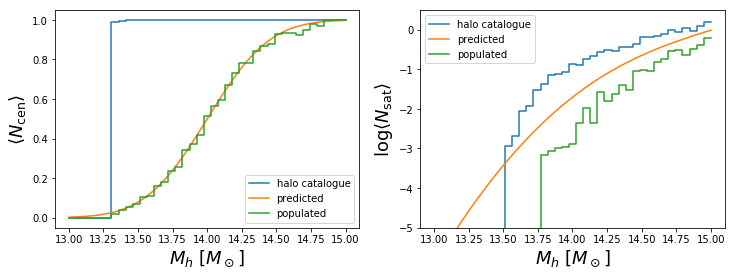

In [31]:
fig = plt.figure( figsize = ( 12, 4 ) )
ax1 = fig.add_subplot( 121 )

ax1.set_xlabel('$M_h$ $[M_\\odot]$', fontsize=18)
ax1.set_ylabel('$\\langle N_\\mathrm{cen} \\rangle$', fontsize=18)

ax1.step( np.log10( ms_binned ), Nc_hal,
          label = 'halo catalogue' )
ax1.plot( np.log10( ms_binned ), [ ocp.Ncen( mm ) for mm in ms_binned ], 
          label = 'predicted' )
ax1.step( np.log10( ms_binned ), Nc_gxy,
          label = 'populated' )

ax1.legend()

ax2 = fig.add_subplot( 122 )

ax2.set_ylim( [ -5, 0.5 ] )
ax2.set_xlabel('$M_h$ $[M_\\odot]$', fontsize=18)
ax2.set_ylabel('$\\log \\langle N_\\mathrm{sat} \\rangle$', fontsize=18)

ax2.step( np.log10( ms_binned ), np.log10( Ns_hal + 1.e-7 ),
          label = 'halo catalogue' )
ax2.plot( np.log10( ms_binned ), np.log10( [ ocp.Nsat( mm ) for mm in ms_binned ] ), 
          label = 'predicted' )
ax2.step( np.log10( ms_binned ), np.log10( Ns_gxy + 1.e-7 ),
          label = 'populated' )

ax2.legend()

### Simulation box:

To have an idea of how the original halo catalogue has been trimmed by the HOD prescription, we show here a slice of the simulation box with positions of the haloes and mock galaxies.

Extract the halo coordinates from the original catalogue and select a $64\ \text{Mpc}/h$ slice along the z-axis:

In [23]:
coords_hal = np.concatenate( ( cat.get_coord_cen(), cat.get_coord_sat() ) ).T
wz_hal = np.where( [ ( 224. < _z ) & ( _z < 288. ) for _z in coords_hal[ 2 ] ] )

Extract the halo coordinates from the populated catalogue and select a $64\ \text{Mpc}/h$ slice along the z-axis:

In [24]:
coords_gxy = np.concatenate( ( gxy_cat.get_coord_cen(), gxy_cat.get_coord_sat() ) ).T
wz_gxy = np.where( [ ( 224. < _z ) & ( _z < 288. ) for _z in coords_gxy[ 2 ] ] )

Plot the slice:

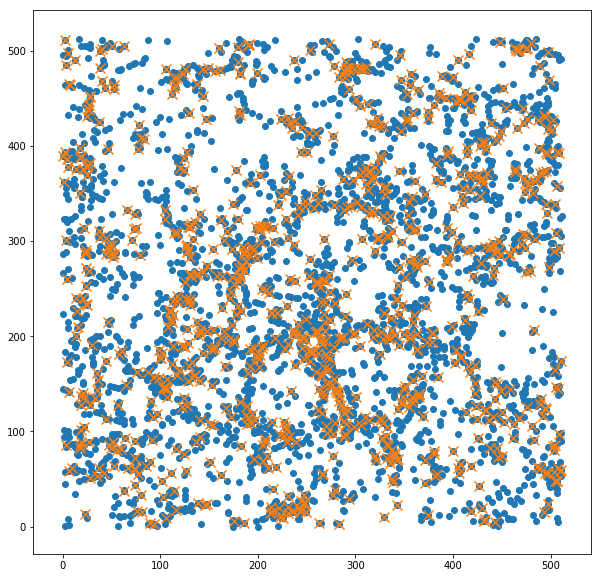

In [26]:
figure( figsize = ( 10, 10 ) )

pyplot.scatter( coords_hal[ 0 ][ wz_hal ], coords_hal[ 1 ][ wz_hal ] )
pyplot.scatter( coords_gxy[ 0 ][ wz_gxy ], coords_gxy[ 1 ][ wz_gxy ], marker='x', s = 100 )

### Luminosity function:

Finally, we want to see what is the luminosity distribution of the output galaxy mock catalogue.
Let us store the luminosities of all the mock galaxies into a `numpy array`:

In [13]:
luminosities = np.array( [ gxy.luminosity for gxy in galaxies ] )

We will now call the `cumulative_counts` function of the `abundance_matching` module.
This function is also used internally by the function that applies the SHAM prescription.
Internally, it counts the number of occurrencies in an array with value **greater** than some fixed quantity, therefore, we have to invert the magnitudes sign to make it work:

In [14]:
mag_mes = np.linspace( -19., -17., 10 )
phi_mes, phi_mes_er = abundance_matching.cumulative_counts( -1 * luminosities, -1 * mag_mes, 1. / volume )

We can now plot the result, along with the integrated Schechter luminosity function.
The latter can be obtained with the utility function `cumulative_from_differential` of the `abundance_matching` module:

<ErrorbarContainer object of 3 artists>

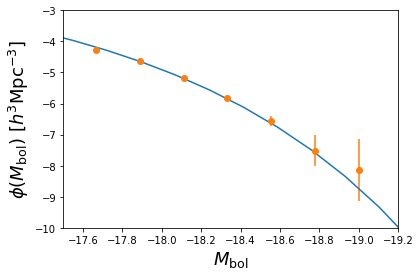

In [22]:
plt.xlabel( '$M_\mathrm{bol}$', fontsize = 18 )
plt.ylabel( '$\phi( M_\mathrm{bol} )\ [h^3 \mathrm{Mpc}^{-3}]$', fontsize = 18 )

plt.xlim( [ -17.5, -19.2 ] )
plt.ylim( [ -10, -3 ] )

size = 30
MM = np.linspace( -21, -16., size )

plot( MM, np.log10( abundance_matching.cumulative_from_differential( schechter, MM ) ) )
errorbar( mag_mes, np.log10( phi_mes ), 
          yerr = phi_mes_er / phi_mes, fmt = 'o' )